# Damage model 
The original model is 

\begin{equation}\label{eq: original model}
y^*  = y \cdot I\{c \cdot y > l\} + \alpha \cdot y \cdot I\{c \cdot y < l\}
\end{equation}



# Smooth function

Note that we have the indicator function in the model we might consider the smooth function:
\begin{equation}\label{eq: trans function}
S(x;s) = \frac{1}{1 + \exp(-s \cdot x)}
\end{equation},
where $s$ is the smoothing hyper-parameter to control the smoothness. 

Then the model becomes 
$$
y^*  = y \cdot \frac{1}{1 + \exp(-s\cdot(cy-l))} + \alpha \cdot y \cdot \frac{1}{1 + \exp(-s\cdot(l-cy))}
$$

We have $y \geq y^*$.

The lumber have three groups:

- Group 1: $y <l$, $y^* < l$, i.e., $y^* <y < l$. The lumber pieces are broken blow the proof loading.
- Group 2: $y >l$, $y^* < l$, i.e. $y^*<l<y$. The lumber pieces are broken during the proof loading process. This groups we only knows how many pieces. 

update: this group should be $0<y^*<l<y$. So $F_y(h^{-1}(l)) - F_y(h^{-1}(\max(0,h^{-1}(l)))$
- Group 3: $y >l$, $y^* > l$, i.e. $l<y^*<y$. The lumber pieces survived in the proof-loading. And then we destruct them to test their strength.


# The PDF calculation 

Given $Y \sim N(\mu, \sigma^2)$, $Y^* = h(Y)$. Then the pdf of $Y^*$,
$$
f_{Y^*}(y^*) = f_{Y}(h^{-1}(y^*))|\frac{d}{dy^*}h^{-1}(y^*)|,
$$
where $f_Y()$ is the pdf of $Y$, i.e., normal. 

Following this, We need the numerical function of $h^{-1}(y^*)$, and its numerical gradient $\frac{d}{dy^*}h^{-1}(y^*)$. (The analytical form doesn't seem available.)

# The range of alpha

For the model 

\begin{equation}
y^*  = y \cdot I\{c \cdot y > l\} + \alpha \cdot y \cdot I\{c \cdot y < l\}.
\end{equation}

What happened if $\alpha < c$?

then $\alpha*y < c*y <l $. It means that all damaged pieces are censored. So we don't have damaged pieces. The remaining pieces in group 3 are all undamaged. Then we can only have the range of $\alpha$ but no specific estimate.

In bivarite dataset, we don't have this problem because we have $c*x$ and $\alpha*y$.

In [177]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp
import pandas
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import scipy

In [178]:
@jax.jit

def indicator(x):
    return(jnp.select([x>0,x<=0],[1,0]))

def logit(x):
    return(jnp.log(x/(1-x)))


def expit(x):
    return 1/(1+jnp.exp(-x))

def exp_smooth(x):
    return(jnp.select(
    [x >0, x<=0],[jnp.exp(-1/(x+ 0.001)),0]))

def g_smooth(x):
    return(exp_smooth(x)/(exp_smooth(x) + exp_smooth(1-x)))

def sigmoid(x, s):
    # x = jnp.array(x)
    # a = jnp.array(a)
    return 0.5 * (jnp.tanh(x * s / 2) + 1)

def dmgmodel_ind(y,alpha,l,c):
    return(y*indicator(c*y-l) + alpha*y*indicator(l-c*y))


def dmgmodel_py(y,alpha,l,c,s):
    #return(y*jax.scipy.stats.norm.cdf(c*y-l) + alpha*y*jax.scipy.stats.norm.cdf(l-c*y))
    return(y*sigmoid(c*y-l,s) + alpha*y*sigmoid(l-c*y,s))

    #return(y*g_smooth(c*y-l) + alpha*y*g_smooth(l-c*y))

def dmgmodel_root_py(y,alpha,l,c,s,ystar):
    return(dmgmodel_py(y,alpha,l,c,s) - ystar)



def dmginverse_py(ystar,alpha,l,c,s):
    ystar = jnp.array(ystar)
    bisec = jaxopt.Bisection(
        optimality_fun=dmgmodel_root_py,
        lower = 0,
        upper = 10000,
        check_bracket = False)
    return(bisec.run(alpha = alpha,l = l, c= c ,s = s,ystar = ystar).params)

def dmginvgrad_py(ystar,alpha,l,c,s):
    grad_func = jax.grad(dmginverse_py,0)
    return(jnp.abs(grad_func(ystar,alpha,l,c,s)))

def dmglik_py(ystar,alpha,l,c,s,mu,sigma):
    y =  dmginverse_py(ystar,alpha,l,c,s)
    return(jax.scipy.stats.norm.logpdf(y,loc = mu,scale = sigma)+ 
           jnp.log(dmginvgrad_py(ystar,alpha,l,c,s))
          )


def dmglik_vmap(y_group,alpha,l,c,s,mu,sigma):
    y_group = jnp.array(y_group)
    lik = jax.vmap(lambda y_group: dmglik_py(ystar = y_group,
                                             alpha = alpha,l = l, c= c,s =s,mu = mu, sigma=sigma))(y_group)
    return(jnp.sum(lik))



In [264]:
def dmginverse_py2(ystar,alpha,l,c,s):
    """
    Calculate the root of `Teqn()`.
    """
    def root_fun(y):
        return dmgmodel_root_py(y = y,alpha = alpha,l = l,
                                c = c,s = s,ystar = ystar)

    def solve(root_fun, Ts_init):
        bisec = jaxopt.Bisection(
            optimality_fun=root_fun,
            lower = 0,
            upper = 10000,
            check_bracket=False
        )
        return bisec.run().params

    def tangent_solve(g, y):
        return y/g(1.0)

    return jax.lax.custom_root(
        f=root_fun,
        initial_guess=50., # dummy value
        solve=solve,
        tangent_solve=tangent_solve,
        has_aux=False   # could set this to True if we wanted to return convergence results from `bisec.run()`
    )

In [265]:
# dmginverse_py(ystar = 50,alpha = 0.2,l = 32,c = 0.7,s = 10)
# dmginverse_py2(ystar = 50,alpha = 0.2,l = 32,c = 0.7,s = 10)

Array(49.999992, dtype=float32)

Array(49.999992, dtype=float32)

# real data 

In [179]:
import pandas
import numpy as np

realdata = pandas.read_csv("bending-pl.csv", header = None)
realdata[0] = realdata[0]/1000*6.895

# l = 4500/1000*6.895
# # R100id = (realdata[1] == "R100")
# # R100 = jnp.array(realdata[realdata[1] == "R100"][0])


# R100 = jnp.array(realdata[realdata[1] == "R100"][0])
# R20 = jnp.array(realdata[realdata[1] == "R20"][0])
# R20R100 = jnp.array(realdata[realdata[1] == "R20R100"][0])


In [180]:
realdata = pandas.read_csv("bending-pl-4groups.csv", header = None)
realdata[0] = realdata[0]/1000*6.895
set(realdata[1])

l_1 = 4500/1000*6.895
l_2 = 3000/1000*6.895


R100 = jnp.array(realdata[realdata[1] == "R100"][0])
R20 = jnp.array(realdata[realdata[1] == "R20"][0])
R20R100 = jnp.array(realdata[realdata[1] == "R20R100"][0])
R20_g2 = 97
#R20_g2 = 92
R20_4Y = jnp.array(realdata[realdata[1] == "R20_4Y"][0])
R20_4Y_R100 = jnp.array(realdata[realdata[1] == "R20_4Y_R100"][0])
R20_4Y_g2 = 41
#R20_4Y_g2 = 41

R5 = jnp.array(realdata[realdata[1] == "R5"][0])
R5R100 = jnp.array(realdata[realdata[1] == "R5R100"][0])
R5_g2 = 42
#R5_g2 = 44




{'R100', 'R20', 'R20R100', 'R20_4Y', 'R20_4Y_R100', 'R5', 'R5R100'}

In [207]:
s = 10
@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    c = theta[2]
    #alpha = jnp.exp(theta[2])
    alpha_R20 = theta[3]
    alpha_R20_4Y = theta[4]
    alpha_R5 = theta[5]
    #s = theta[4]
    #s = jnp.exp(theta[4])
    #lik1 = jnp.sum(jnp.log(jax.vmap(lambda y: jax.scipy.stats.norm.pdf(y,loc = mu, scale = sigma))(y_obs_g1)))
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(R20,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik2 = R20_g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l_1,alpha_R20,l_1,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l_1, loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = R20R100,alpha = alpha_R20,l = l_1, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(R100,loc = mu, scale = sigma))
   
    lik5 = jnp.sum(jax.scipy.stats.norm.logpdf(R20_4Y,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik6 = R20_4Y_g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l_1,alpha_R20_4Y,l_1,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l_1, loc=mu, scale=sigma)
    )
    lik7 = dmglik_vmap(y_group = R20_4Y_R100,alpha = alpha_R20_4Y,l = l_1, c = c,s = s, mu = mu, sigma = sigma)
    
    lik8 = jnp.sum(jax.scipy.stats.norm.logpdf(R5,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik9 = R5_g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l_2, alpha_R5,l_2,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l_2, loc=mu, scale=sigma)
    )
    lik10 = dmglik_vmap(y_group = R5R100,alpha =  alpha_R5,l = l_2, c = c,s = s, mu = mu, sigma = sigma)
    

    return(-lik1 - lik2-lik3- lik4 - lik5 - lik6 - lik7 - lik8 - lik9 -lik10)

#theta0 = jnp.array([mu,sigma,jnp.log(alpha),c,jnp.log(s)])

theta0 = jnp.array([48,19,0.5,0.8,.8,.8])

negdmglik_jax(theta0)

Array(3085.267, dtype=float32)

In [182]:
# import pandas
# import numpy as np

# realdata = pandas.read_csv("bending-pl.csv", header = None)
# realdata[0] = realdata[0]/1000*6.895

# l = 4500/1000*6.895
# # R100id = (realdata[1] == "R100")
# # R100 = jnp.array(realdata[realdata[1] == "R100"][0])


# R100 = jnp.array(realdata[realdata[1] == "R100"][0])
# R20 = jnp.array(realdata[realdata[1] == "R20"][0])
# R20R100 = jnp.array(realdata[realdata[1] == "R20R100"][0])

# g2 = 97



# s= 10
# l = l
# R100 = R100
# R20 = R20
# R20R100 = R20R100
# g2 = 97
# @jax.jit
# def negdmglik_jax(theta):
#     mu = theta[0]
#     sigma = theta[1]
#     alpha = theta[2]
#     #alpha = jnp.exp(theta[2])
#     c = theta[3]
#     #s = theta[4]
#     #s = jnp.exp(theta[4])
#     #lik1 = jnp.sum(jnp.log(jax.vmap(lambda y: jax.scipy.stats.norm.pdf(y,loc = mu, scale = sigma))(y_obs_g1)))
#     lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(R20,loc = mu, scale = sigma))
#     #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik2 = g2*jnp.log(
#         jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
#         jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
#     )
#     lik3 = dmglik_vmap(y_group = R20R100,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(R100,loc = mu, scale = sigma))

#     return(-lik1 - lik2-lik3- lik4)

# #theta0 = jnp.array([mu,sigma,jnp.log(alpha),c,jnp.log(s)])

# theta0 = jnp.array([mu,sigma,alpha,c])

# negdmglik_jax(theta0)

In [183]:
# min(R20R100)
# l/res.params[3]

In [208]:
#solver = jaxopt.LBFGS(fun=negdmglik_jax)
# res = solver.run(theta0)



solver = jaxopt.ScipyMinimize(method = "SLSQP",fun=negdmglik_jax)
res = solver.run(theta0)

res.params
theta0

# Array(1678.6377, dtype=float32)
negdmglik_jax(res.params)

Array([46.343792  , 17.73139   ,  0.6610804 ,  0.64025235,  0.6516938 ,
       -0.4567203 ], dtype=float32)

Array([48. , 19. ,  0.5,  0.8,  0.8,  0.8], dtype=float32)

Array(2813.413, dtype=float32)

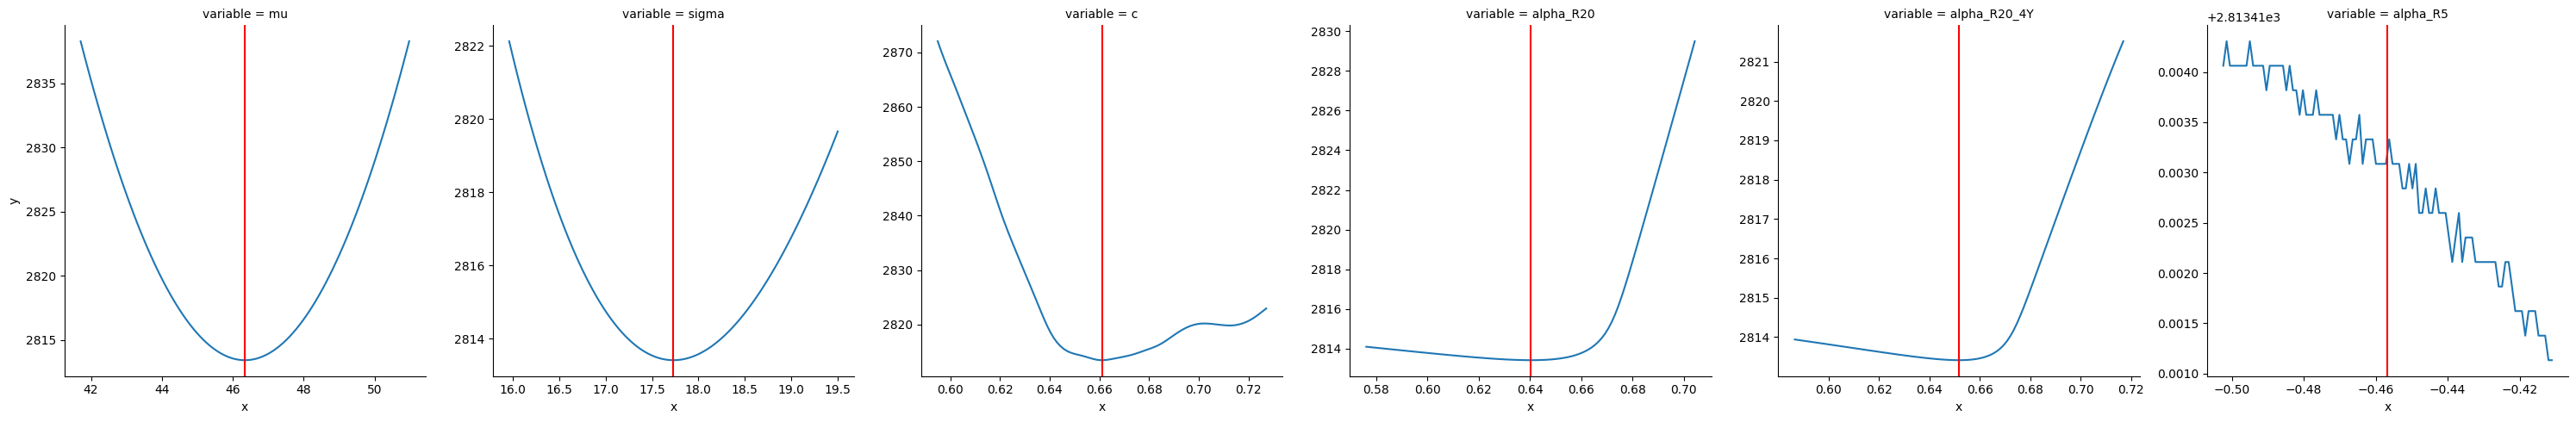

In [209]:
xsol = res.params
xrange = .1
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
#theta_rng = theta_rng.at[2,:].set(jnp.array([0.1,0.9]))
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng,
    x_names = ['mu','sigma','c','alpha_R20','alpha_R20_4Y','alpha_R5'],
    n_pts=100, 
    opt_vlines=True
)

In [112]:
# xsol = res.params
# xrange = .01
# theta_upper = xsol  + xrange *jnp.abs(xsol)
# theta_lower = xsol - xrange * jnp.abs(xsol)
# theta_rng_trans = jnp.array([theta_lower, theta_upper])

# #res.params
# theta_rng = jnp.transpose(theta_rng_trans)
# #theta_rng = theta_rng.at[2,:].set(jnp.array([0.1,0.9]))
# # plot at the true value theta0
# pjp.proj_plot(
#     fun=negdmglik_jax,
#     x_opt=xsol,
#     x_lims=theta_rng,
#     x_names = ['mu','sigma','c','alpha_R20','alpha_R20_4Y','alpha_R5'],
#     n_pts=100, 
#     opt_vlines=True
# )

In [210]:
#R20
trunc_mean = scipy.stats.truncnorm.mean((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])
trunc_var = scipy.stats.truncnorm.var((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])

sample_mean = trunc_mean
sample_var = trunc_var/R20R100.shape[-1]


test_stat = (np.mean(R20R100) - sample_mean)/np.sqrt(sample_var)
scipy.stats.norm.cdf(test_stat)

0.7411603852254891

In [211]:
#R20_4Y
trunc_mean = scipy.stats.truncnorm.mean((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])
trunc_var = scipy.stats.truncnorm.var((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])

sample_mean = trunc_mean
sample_var = trunc_var/R20_4Y_R100.shape[-1]


test_stat = (np.mean(R20_4Y_R100) - sample_mean)/np.sqrt(sample_var)
scipy.stats.norm.cdf(test_stat)


np.mean(R20_4Y_R100) 
trunc_mean

0.001260577353962446

Array(55.6143, dtype=float32)

60.86960377781336

In [212]:
#R5_4Y
trunc_mean = scipy.stats.truncnorm.mean((l_2/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])
trunc_var = scipy.stats.truncnorm.var((l_2/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])

sample_mean = trunc_mean
sample_var = trunc_var/R5R100.shape[-1]


test_stat = (np.mean(R5R100) - sample_mean)/np.sqrt(sample_var)
scipy.stats.norm.cdf(test_stat)

0.26342502954611785

# remove unsignificant

In [247]:
s = 10
@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    c = theta[2]
    #alpha = jnp.exp(theta[2])
    alpha_R20 = theta[3]
    alpha_R20_4Y = theta[4]
    alpha_R5 = .1
    #s = theta[4]
    #s = jnp.exp(theta[4])
    #lik1 = jnp.sum(jnp.log(jax.vmap(lambda y: jax.scipy.stats.norm.pdf(y,loc = mu, scale = sigma))(y_obs_g1)))
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(R20,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik2 = R20_g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l_1,alpha_R20,l_1,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l_1, loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = R20R100,alpha = alpha_R20,l = l_1, c = c,s = s, mu = mu, sigma = sigma)
    
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(R100,loc = mu, scale = sigma))
   
    lik5 = jnp.sum(jax.scipy.stats.norm.logpdf(R20_4Y,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik6 = R20_4Y_g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l_1,alpha_R20_4Y,l_1,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l_1, loc=mu, scale=sigma)
    )
    lik7 = dmglik_vmap(y_group = R20_4Y_R100,alpha = alpha_R20_4Y,l = l_1, c = c,s = s, mu = mu, sigma = sigma)
    
#     lik8 = jnp.sum(jax.scipy.stats.norm.logpdf(R5,loc = mu, scale = sigma))
#     #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik9 = R5_g2*jnp.log(
#         jax.scipy.stats.norm.cdf(dmginverse_py(l_2, alpha_R5,l_2,c,s), loc=mu, scale=sigma) - 
#         jax.scipy.stats.norm.cdf(l_2, loc=mu, scale=sigma)
#     )
#     lik10 = dmglik_vmap(y_group = R5R100,alpha =  alpha_R5,l = l_2, c = c,s = s, mu = mu, sigma = sigma)
    
    return(-lik1 - lik2-lik3- lik4 - lik5 - lik6 - lik7 )
    #return(-lik1 - lik2-lik3- lik4 - lik5 - lik6 - lik7 - lik8 - lik9 -lik10)

#theta0 = jnp.array([mu,sigma,jnp.log(alpha),c,jnp.log(s)])

theta0 = jnp.array([48,19,0.6,.8,.8])

negdmglik_jax(theta0)

Array(2169.2844, dtype=float32)

In [248]:
# solver = jaxopt.LBFGS(fun=negdmglik_jax)
# res = solver.run(theta0)



solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(theta0)

res.params
theta0

# Array(1678.6377, dtype=float32)
negdmglik_jax(res.params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Array([45.855835  , 18.091497  ,  0.71768194,  0.64508855,  0.68958026],      dtype=float32)

Array([48. , 19. ,  0.6,  0.8,  0.8], dtype=float32)

Array(2047.9258, dtype=float32)

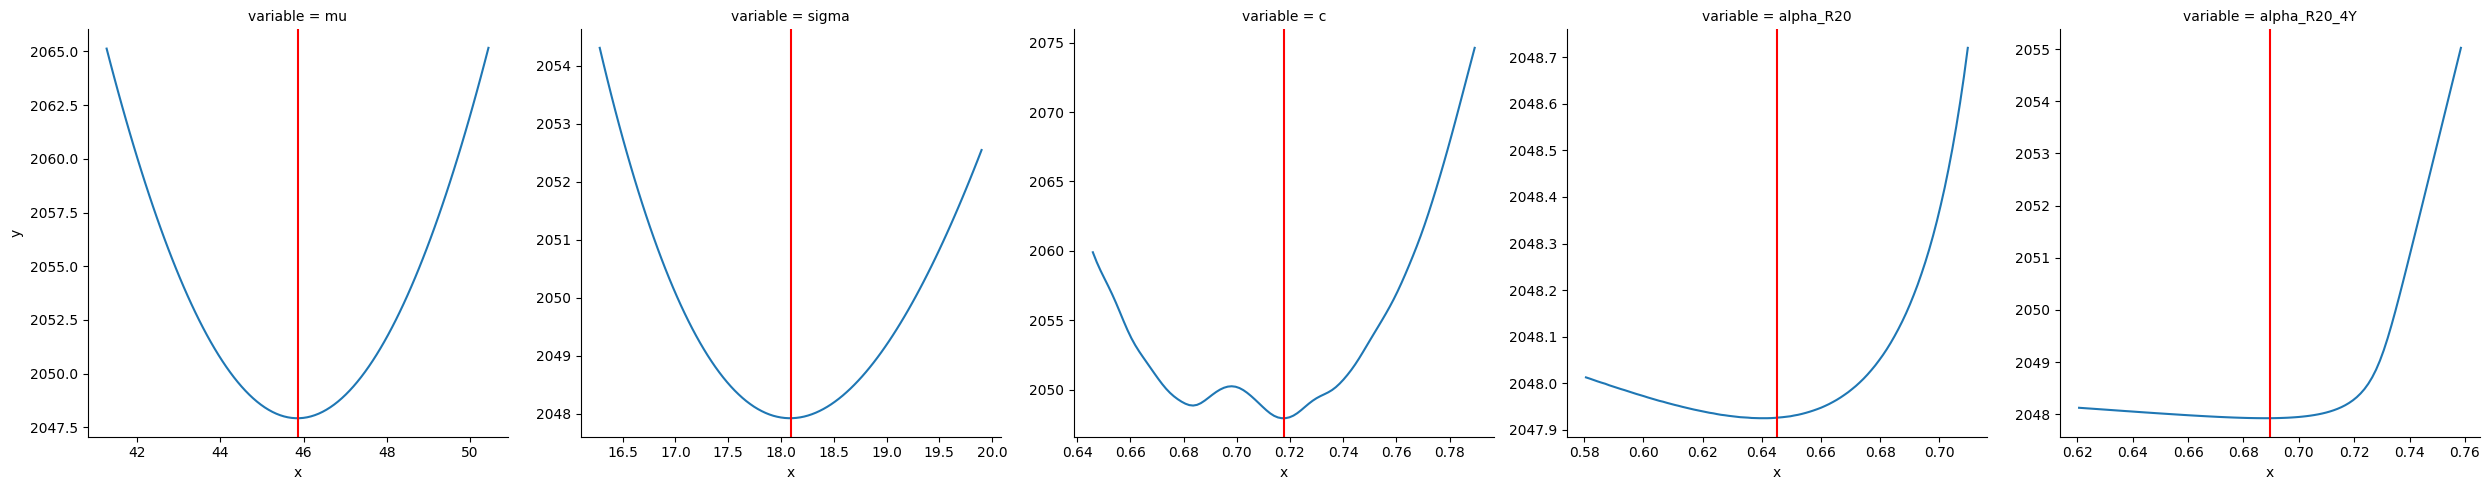

In [249]:
xsol = res.params
xrange = .1
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
#theta_rng = theta_rng.at[2,:].set(jnp.array([0.1,0.9]))
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng,
    x_names = ['mu','sigma','c','alpha_R20','alpha_R20_4Y'],
    n_pts=100, 
    opt_vlines=True
)

In [17]:
# xsol = res.params
# xrange = .01
# theta_upper = xsol  + xrange *jnp.abs(xsol)
# theta_lower = xsol - xrange * jnp.abs(xsol)
# theta_rng_trans = jnp.array([theta_lower, theta_upper])

# #res.params
# theta_rng = jnp.transpose(theta_rng_trans)
# #theta_rng = theta_rng.at[2,:].set(jnp.array([0.1,0.9]))
# # plot at the true value theta0
# pjp.proj_plot(
#     fun=negdmglik_jax,
#     x_opt=xsol,
#     x_lims=theta_rng,
#     x_names = ['mu','sigma','c','alpha_R20_4Y'],
#     n_pts=100, 
#     opt_vlines=True
# )

In [250]:
#R20_4Y
trunc_mean = scipy.stats.truncnorm.mean((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])
trunc_var = scipy.stats.truncnorm.var((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])

sample_mean = trunc_mean
sample_var = trunc_var/R20R100.shape[-1]


test_stat = (np.mean(R20R100) - sample_mean)/np.sqrt(sample_var)
scipy.stats.norm.cdf(test_stat)

0.998369881486134

In [251]:
#R20_4Y
trunc_mean = scipy.stats.truncnorm.mean((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])
trunc_var = scipy.stats.truncnorm.var((l_1/res.params[2] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])

sample_mean = trunc_mean
sample_var = trunc_var/R20_4Y_R100.shape[-1]


test_stat = (np.mean(R20_4Y_R100) - sample_mean)/np.sqrt(sample_var)
scipy.stats.norm.cdf(test_stat)

0.051681465435359564

In [252]:
np.mean(R20_4Y_R100) 
trunc_mean

Array(55.6143, dtype=float32)

58.66347790950407